In [1]:
#Librerias principales
import pandas as pd
import seaborn as sns
import sklearn as sk
import sqlalchemy as sqla
import pyodbc as pyodbc
import numpy as np
from sqlalchemy import create_engine, MetaData, table, select
import pymssql as pymssql
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve
)


In [2]:
#Configura la cadena de conexión
server = 'SGF1025'  # Reemplaza con el nombre de tu servidor
database = 'Almacen_de_Datos'  # Reemplaza con el nombre de tu base de datos

# Cadena de conexión con autenticación de Windows
connection_string = f"mssql+pyodbc://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"

# Crear el motor de SQLAlchemy
engine = create_engine(connection_string)

# Consulta SQL 
query = """
SELECT * FROM [dbo].[DF_Pred_Emitida]
 ;
"""

# Cargar datos en un DataFrame
df_sql = pd.read_sql(query, engine)

# Mostrar las primeras filas
print(df_sql.head())

# Mostrar información del DataFrame
print(df_sql.info())

   RN  ID_COTIZACION   AÑO  PRIMAUF_COTIZADA_sIVA  emitida  \
0   1              1  2012              17.042017        0   
1   1              3  2018              18.890756        0   
2   1             35  2022              18.142857        0   
3   1             37  2013              10.260504        0   
4   1             42  2011              14.789916        0   

   ANIO_MES_COTIZACION     EDAD      GSE   tipo_veh ANTVEH DEDUCIBLE  \
0               202503       75        D        Van     13         0   
1               202503  UNKNOWN  UNKNOWN    UNKNOWN      7         0   
2               202503       85      C1B        Suv      3         0   
3               202503       81       C2  Hatchback     12         0   
4               202503  UNKNOWN  UNKNOWN  Hatchback     14         0   

    BC_TOTAL  PRIMA_TECNICA      APTP  
0   6.555522      11.981654  1.422343  
1  10.009452      18.294468  1.032594  
2   7.867441      14.379473  1.261719  
3   4.877523       8.914742  1.150

In [3]:
# Preprocesar la variable EDAD
def preprocess_age(age): #funcion que procesa la variable edad
    if age == '90 o mas': #SI edad posee el valor '90 o mas'
        return 90 #retorne un valor 90 en su lugar
    try:
        return float(age) #lo retorna en formato float
    except:
        return np.nan

df_sql['EDAD'] = df_sql['EDAD'].apply(preprocess_age) #se aplica la funcion a la columna EDAD

In [4]:
df_sql
##94221 rows × 14 columns

,RN,ID_COTIZACION,AÑO,PRIMAUF_COTIZADA_sIVA,emitida,ANIO_MES_COTIZACION,EDAD,GSE,tipo_veh,ANTVEH,DEDUCIBLE,BC_TOTAL,PRIMA_TECNICA,APTP
0,1,1,2012,17.042017,0,202503,75.0,D,Van,13,0,6.555522,11.981654,1.422343
1,1,3,2018,18.890756,0,202503,NaN,UNKNOWN,UNKNOWN,7,0,10.009452,18.294468,1.032594
2,1,35,2022,18.142857,0,202503,85.0,C1B,Suv,3,0,7.867441,14.379473,1.261719
3,1,37,2013,10.260504,0,202503,81.0,C2,Hatchback,12,0,4.877523,8.914742,1.150959
4,1,42,2011,14.789916,0,202503,NaN,UNKNOWN,Hatchback,14,0,4.931625,9.013626,1.640840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94216,1,244746,2022,18.378151,0,202503,29.0,AB,Van,3,0,24.017436,43.897129,0.418664
94217,1,244748,2015,29.302521,0,202503,29.0,C3,Suv,10,0,11.601133,21.203614,1.381959
94218,1,244782,2023,15.294118,0,202503,29.0,C1B,Camioneta,2,0,9.355966,17.100078,0.894389
94219,1,244805,2025,34.210084,0,202503,29.0,C3,Suv,0,0,23.227297,42.452976,0.805835


In [5]:
# Suponiendo que tu DataFrame se llama 'df'
print("Valores únicos en 'ANTVEH':", df_sql['ANTVEH'].unique())
print("Valores únicos en 'DEDUCIBLE':", df_sql['DEDUCIBLE'].unique())


# Opcional: Contar frecuencias de cada valor (útil para identificar categorías)
print("\nFrecuencia en 'ANTVEH':\n", df_sql['ANTVEH'].value_counts())
print("\nFrecuencia en 'DEDUCIBLE':\n", df_sql['DEDUCIBLE'].value_counts())

Valores únicos en 'ANTVEH': ['13' '7' '3' '12' '14' '6' '11' '0' '4' '5' '10' '16 o mas' '8' '15' '1'
 '9' '2']
Valores únicos en 'DEDUCIBLE': ['0' '3' '5' '12' '15' '8' '20']

Frecuencia en 'ANTVEH':
 ANTVEH
2           11885
1           11118
3           10516
4            9840
0            8596
6            8498
7            5502
5            5439
8            5357
9            3223
11           3091
10           2976
12           2970
14           2524
13           2369
16 o mas      169
15            148
Name: count, dtype: int64

Frecuencia en 'DEDUCIBLE':
 DEDUCIBLE
0     93411
3       516
5       195
12       63
15       22
8        10
20        4
Name: count, dtype: int64


In [6]:
#Cambiamos la variable 16 o mas por la variable 16
df_sql['ANTVEH'] = df_sql['ANTVEH'].replace('16 o mas', 16)
df_sql['DEDUCIBLE'] = df_sql['DEDUCIBLE'].replace('0', 'Sin Deducible')
df_sql['DEDUCIBLE'] = df_sql['DEDUCIBLE'].replace('3', '3D')
df_sql['DEDUCIBLE'] = df_sql['DEDUCIBLE'].replace('5', '5D')
df_sql['DEDUCIBLE'] = df_sql['DEDUCIBLE'].replace('12', '12D')
df_sql['DEDUCIBLE'] = df_sql['DEDUCIBLE'].replace('15', '15D')
df_sql['DEDUCIBLE'] = df_sql['DEDUCIBLE'].replace('8', '8D')
df_sql['DEDUCIBLE'] = df_sql['DEDUCIBLE'].replace('20', '20D')


print("Valores únicos en 'DEDUCIBLE':", df_sql['DEDUCIBLE'].unique())


Valores únicos en 'DEDUCIBLE': ['Sin Deducible' '3D' '5D' '12D' '15D' '8D' '20D']


In [7]:
df_sql
###94221 rows × 14 columns

,RN,ID_COTIZACION,AÑO,PRIMAUF_COTIZADA_sIVA,emitida,ANIO_MES_COTIZACION,EDAD,GSE,tipo_veh,ANTVEH,DEDUCIBLE,BC_TOTAL,PRIMA_TECNICA,APTP
0,1,1,2012,17.042017,0,202503,75.0,D,Van,13,Sin Deducible,6.555522,11.981654,1.422343
1,1,3,2018,18.890756,0,202503,NaN,UNKNOWN,UNKNOWN,7,Sin Deducible,10.009452,18.294468,1.032594
2,1,35,2022,18.142857,0,202503,85.0,C1B,Suv,3,Sin Deducible,7.867441,14.379473,1.261719
3,1,37,2013,10.260504,0,202503,81.0,C2,Hatchback,12,Sin Deducible,4.877523,8.914742,1.150959
4,1,42,2011,14.789916,0,202503,NaN,UNKNOWN,Hatchback,14,Sin Deducible,4.931625,9.013626,1.640840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94216,1,244746,2022,18.378151,0,202503,29.0,AB,Van,3,Sin Deducible,24.017436,43.897129,0.418664
94217,1,244748,2015,29.302521,0,202503,29.0,C3,Suv,10,Sin Deducible,11.601133,21.203614,1.381959
94218,1,244782,2023,15.294118,0,202503,29.0,C1B,Camioneta,2,Sin Deducible,9.355966,17.100078,0.894389
94219,1,244805,2025,34.210084,0,202503,29.0,C3,Suv,0,Sin Deducible,23.227297,42.452976,0.805835


In [8]:
# valores unicos en EDAD
print("Valores únicos en 'EDAD':", df_sql['EDAD'].unique())



# Frecuencias en EDAD
print("\nFrecuencia en 'EDAD':\n", df_sql['EDAD'].value_counts())


Valores únicos en 'EDAD': [75. nan 85. 81. 79. 84. 30. 77. 82. 83. 76. 80. 78. 73. 74. 71. 70. 63.
 72. 66. 62. 61. 55. 59. 57. 64. 51. 58. 67. 68. 53. 65. 69. 54. 60. 56.
 52. 49. 50. 86. 87. 48. 47. 41. 44. 46. 45. 42. 43. 40. 39. 38. 37. 29.
 36. 35. 34. 25. 26. 31. 32. 33. 18. 24. 21. 20. 19. 28. 27. 22. 23.]

Frecuencia en 'EDAD':
 EDAD
39.0    3701
47.0    3631
29.0    3162
32.0    2724
55.0    2634
        ... 
83.0      43
84.0      25
85.0      22
86.0      11
87.0       2
Name: count, Length: 70, dtype: int64


In [9]:
# Cargaremos el dataset en la vairable df
df = df_sql.copy()

# Variables categóricas y numéricas
categorical_features = ['DEDUCIBLE']
numeric_features = ['PRIMAUF_COTIZADA_sIVA', 'EDAD', 'BC_TOTAL', 'APTP', 'AÑO', 'ANTVEH']

# Reemplazar 'UNKNOWN' con categoría explícita
for col in categorical_features:
    df[col] = df[col].replace('UNKNOWN', 'NO_DISPONIBLE')



# Imputar EDAD faltante con la mediana
df['EDAD'] = df['EDAD'].fillna(df['EDAD'].median())

In [10]:
df
##94221 rows × 14 columns

,RN,ID_COTIZACION,AÑO,PRIMAUF_COTIZADA_sIVA,emitida,ANIO_MES_COTIZACION,EDAD,GSE,tipo_veh,ANTVEH,DEDUCIBLE,BC_TOTAL,PRIMA_TECNICA,APTP
0,1,1,2012,17.042017,0,202503,75.0,D,Van,13,Sin Deducible,6.555522,11.981654,1.422343
1,1,3,2018,18.890756,0,202503,43.0,UNKNOWN,UNKNOWN,7,Sin Deducible,10.009452,18.294468,1.032594
2,1,35,2022,18.142857,0,202503,85.0,C1B,Suv,3,Sin Deducible,7.867441,14.379473,1.261719
3,1,37,2013,10.260504,0,202503,81.0,C2,Hatchback,12,Sin Deducible,4.877523,8.914742,1.150959
4,1,42,2011,14.789916,0,202503,43.0,UNKNOWN,Hatchback,14,Sin Deducible,4.931625,9.013626,1.640840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94216,1,244746,2022,18.378151,0,202503,29.0,AB,Van,3,Sin Deducible,24.017436,43.897129,0.418664
94217,1,244748,2015,29.302521,0,202503,29.0,C3,Suv,10,Sin Deducible,11.601133,21.203614,1.381959
94218,1,244782,2023,15.294118,0,202503,29.0,C1B,Camioneta,2,Sin Deducible,9.355966,17.100078,0.894389
94219,1,244805,2025,34.210084,0,202503,29.0,C3,Suv,0,Sin Deducible,23.227297,42.452976,0.805835


In [11]:
df.isnull().sum()


RN                       0
ID_COTIZACION            0
AÑO                      0
PRIMAUF_COTIZADA_sIVA    0
emitida                  0
ANIO_MES_COTIZACION      0
EDAD                     0
GSE                      0
tipo_veh                 0
ANTVEH                   0
DEDUCIBLE                0
BC_TOTAL                 0
PRIMA_TECNICA            0
APTP                     0
dtype: int64

In [12]:
X = df[categorical_features + numeric_features]
y = df['emitida']

# Split de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Índices de features categóricas
cat_features_indices = [X.columns.get_loc(col) for col in categorical_features]

# Pools para CatBoost
train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
test_pool = Pool(X_test, y_test, cat_features=cat_features_indices)

In [13]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    loss_function='Logloss',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=30
)

model.fit(train_pool, eval_set=test_pool, use_best_model=True)

0:	test: 0.6436113	best: 0.6436113 (0)	total: 237ms	remaining: 3m 56s
100:	test: 0.9799690	best: 0.9805430 (80)	total: 10.2s	remaining: 1m 30s
200:	test: 0.9817942	best: 0.9817942 (200)	total: 19.3s	remaining: 1m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9819393211
bestIteration = 210

Shrink model to first 211 iterations.


In [14]:
# Predicciones
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# =======================
# MÉTRICAS CLÁSICAS
# =======================
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18679
           1       0.99      0.89      0.94       166

    accuracy                           1.00     18845
   macro avg       1.00      0.94      0.97     18845
weighted avg       1.00      1.00      1.00     18845

Accuracy: 0.9989
AUC: 0.9819


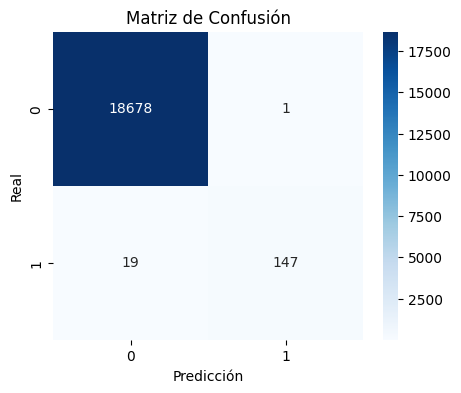

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

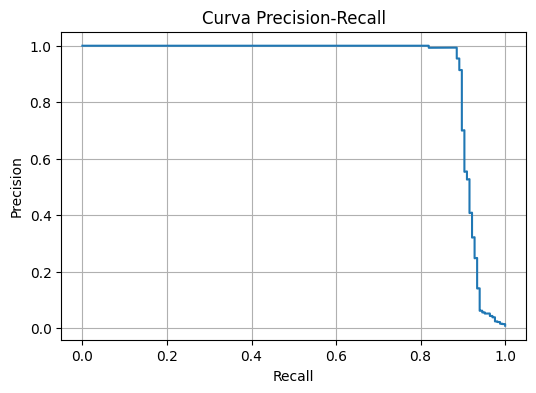

In [16]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

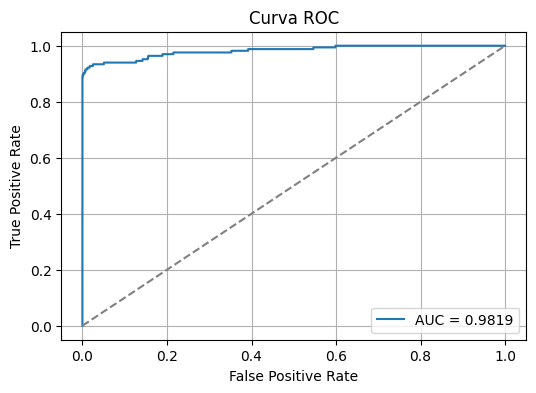

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.4f}')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

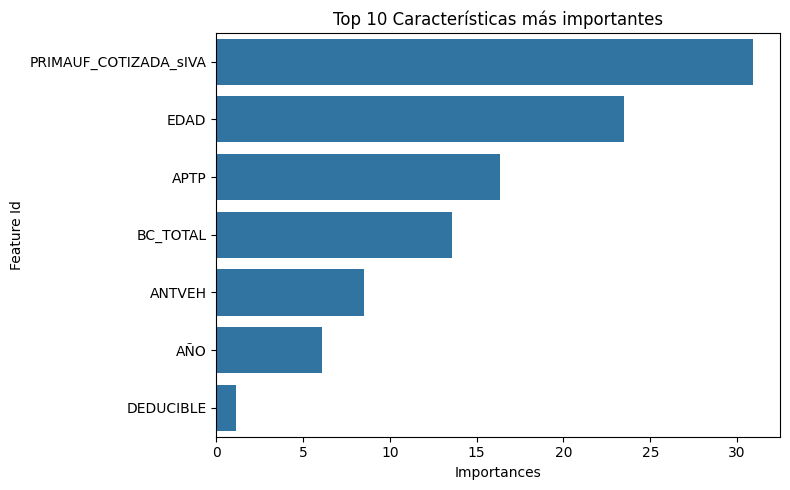


--- Importancia de variables ---
              Feature Id  Importances
0  PRIMAUF_COTIZADA_sIVA    30.926401
1                   EDAD    23.467429
2                   APTP    16.316185
3               BC_TOTAL    13.577808
4                 ANTVEH     8.523436
5                    AÑO     6.079599
6              DEDUCIBLE     1.109142


In [18]:
feature_importance = model.get_feature_importance(prettified=True)
plt.figure(figsize=(8,5))
sns.barplot(x='Importances', y='Feature Id', data=feature_importance.head(10))
plt.title('Top 10 Características más importantes')
plt.tight_layout()
plt.show()

print("\n--- Importancia de variables ---")
print(feature_importance.head(10))

In [19]:
# Crear DataFrame con comparaciones
comparacion_df = pd.DataFrame({
    'emitida_real': y_test.reset_index(drop=True),
    'emitida_predicha': y_pred,
    'probabilidad_predicha': y_prob,
    
})

# Mostrar algunas filas
print("\n--- Comparación emitida real vs predicha ---")
print(comparacion_df.head(10))

# Guardar el DataFrame en un archivo CSV (opcional)
#comparacion_df.to_csv('Comparación_emitida_real_vs_predicha_CatBoost.csv', index=False)


--- Comparación emitida real vs predicha ---
   emitida_real  emitida_predicha  probabilidad_predicha
0             0                 0               0.000084
1             0                 0               0.000031
2             0                 0               0.008409
3             0                 0               0.002967
4             0                 0               0.000368
5             0                 0               0.000370
6             0                 0               0.000462
7             0                 0               0.000275
8             0                 0               0.000448
9             0                 0               0.000780


In [20]:
comparacion_df.describe()

,emitida_real,emitida_predicha,probabilidad_predicha
count,18845.000000,18845.000000,18845.000000
mean,0.008809,0.007854,0.008886
std,0.093443,0.088274,0.088204
min,0.000000,0.000000,0.000006
25%,0.000000,0.000000,0.000086
50%,0.000000,0.000000,0.000274
75%,0.000000,0.000000,0.000949
max,1.000000,1.000000,0.999985


In [21]:
print("\n--- Tabla cruzada (conteo) ---")
print(pd.crosstab(comparacion_df['emitida_real'], comparacion_df['emitida_predicha'], 
                  rownames=['Real'], colnames=['Predicha']))


--- Tabla cruzada (conteo) ---
Predicha      0    1
Real                
0         18678    1
1            19  147


In [22]:
# Resetear índices para alinear correctamente
comparacion_df = comparacion_df.reset_index(drop=True)
X_test_reset = X_test.reset_index(drop=True)
 
# Unimos las predicciones con los datos de test
df_test_completo = pd.concat([X_test_reset, comparacion_df], axis=1)
 
# Mostrar algunos registros
print(df_test_completo.head())

       DEDUCIBLE  PRIMAUF_COTIZADA_sIVA  EDAD   BC_TOTAL      APTP   AÑO  \
0  Sin Deducible              29.100840  69.0   8.468360  1.880168  2022   
1  Sin Deducible              31.907563  44.0  12.172819  1.434145  2025   
2  Sin Deducible              14.663866  67.0   7.197156  1.114751  2022   
3  Sin Deducible              11.857143  39.0   7.469668  0.868499  2025   
4  Sin Deducible              16.957983  54.0   9.389895  0.988107  2025   

  ANTVEH  emitida_real  emitida_predicha  probabilidad_predicha  
0      3             0                 0               0.000084  
1      0             0                 0               0.000031  
2      3             0                 0               0.008409  
3      0             0                 0               0.002967  
4      0             0                 0               0.000368  


**Reentrenamiento full**

In [23]:
X_full = df[categorical_features + numeric_features]
y_full = df['emitida']
 
cat_features_indices = [X_full.columns.get_loc(col) for col in categorical_features]
full_pool = Pool(X_full, y_full, cat_features=cat_features_indices)
 

In [24]:
modelo_final = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    loss_function='Logloss',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=30
)
 
modelo_final.fit(full_pool)

0:	total: 143ms	remaining: 2m 23s
100:	total: 12.3s	remaining: 1m 49s
200:	total: 22.7s	remaining: 1m 30s
300:	total: 35s	remaining: 1m 21s
400:	total: 46s	remaining: 1m 8s
500:	total: 56.2s	remaining: 55.9s
600:	total: 1m 7s	remaining: 44.5s
700:	total: 1m 17s	remaining: 33.2s
800:	total: 1m 30s	remaining: 22.5s
900:	total: 1m 44s	remaining: 11.5s
999:	total: 1m 55s	remaining: 0us


In [25]:
# Hacer predicciones sobre todo el dataset
y_pred_full = modelo_final.predict(X_full)
y_prob_full = modelo_final.predict_proba(X_full)[:, 1]

In [26]:
# Predicción sobre df completo (mismo set)
df['emitida_predicha_full'] = modelo_final.predict(X_full)
df['probabilidad_predicha_full'] = modelo_final.predict_proba(X_full)[:, 1]

In [38]:
# Guardar el modelo en formato .cbm
modelo_final.save_model('modelo_final.cbm')
print("Modelo guardado como 'modelo_final.cbm'")

Modelo guardado como 'modelo_final.cbm'


In [27]:
df

,RN,ID_COTIZACION,AÑO,PRIMAUF_COTIZADA_sIVA,emitida,ANIO_MES_COTIZACION,EDAD,GSE,tipo_veh,ANTVEH,DEDUCIBLE,BC_TOTAL,PRIMA_TECNICA,APTP,emitida_predicha_full,probabilidad_predicha_full
0,1,1,2012,17.042017,0,202503,75.0,D,Van,13,Sin Deducible,6.555522,11.981654,1.422343,0,0.000020
1,1,3,2018,18.890756,0,202503,43.0,UNKNOWN,UNKNOWN,7,Sin Deducible,10.009452,18.294468,1.032594,0,0.000062
2,1,35,2022,18.142857,0,202503,85.0,C1B,Suv,3,Sin Deducible,7.867441,14.379473,1.261719,0,0.000137
3,1,37,2013,10.260504,0,202503,81.0,C2,Hatchback,12,Sin Deducible,4.877523,8.914742,1.150959,0,0.000124
4,1,42,2011,14.789916,0,202503,43.0,UNKNOWN,Hatchback,14,Sin Deducible,4.931625,9.013626,1.640840,0,0.000021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94216,1,244746,2022,18.378151,0,202503,29.0,AB,Van,3,Sin Deducible,24.017436,43.897129,0.418664,0,0.000243
94217,1,244748,2015,29.302521,0,202503,29.0,C3,Suv,10,Sin Deducible,11.601133,21.203614,1.381959,0,0.000002
94218,1,244782,2023,15.294118,0,202503,29.0,C1B,Camioneta,2,Sin Deducible,9.355966,17.100078,0.894389,0,0.000325
94219,1,244805,2025,34.210084,0,202503,29.0,C3,Suv,0,Sin Deducible,23.227297,42.452976,0.805835,0,0.000042


In [28]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
 
print("\n--- Reporte de Clasificación (modelo final sobre todo el dataset) ---")
print(classification_report(y_full, y_pred_full))
print(f"Accuracy: {accuracy_score(y_full, y_pred_full):.4f}")
print(f"AUC: {roc_auc_score(y_full, y_prob_full):.4f}")
 


--- Reporte de Clasificación (modelo final sobre todo el dataset) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93389
           1       1.00      0.94      0.97       832

    accuracy                           1.00     94221
   macro avg       1.00      0.97      0.98     94221
weighted avg       1.00      1.00      1.00     94221

Accuracy: 0.9994
AUC: 0.9995


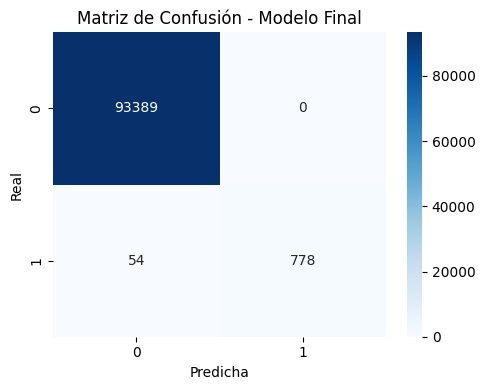

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
 
cm = confusion_matrix(y_full, y_pred_full)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicha")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Modelo Final")
plt.tight_layout()
plt.show()

**Validacion Cruzada**

In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier, Pool
import numpy as np

# Validación cruzada replicando tu modelo_final
def cross_validate_modelo_final(X_full, y_full, categorical_features, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    aucs, accs, f1s = [], [], []

    cat_features_indices = [X_full.columns.get_loc(col) for col in categorical_features]

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_full, y_full)):
        print(f"\n=== Fold {fold+1} ===")
        
        X_train, X_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
        y_train, y_val = y_full.iloc[train_idx], y_full.iloc[val_idx]

        train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
        val_pool = Pool(X_val, y_val, cat_features=cat_features_indices)

        model = CatBoostClassifier(
            iterations=1000,
            learning_rate=0.1,
            depth=6,
            eval_metric='AUC',
            loss_function='Logloss',
            early_stopping_rounds=30,
            verbose=0,
            random_seed=42
        )
        model.fit(train_pool, eval_set=val_pool, use_best_model=True)

        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_prob)
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)

        print(f"AUC: {auc:.4f} | Accuracy: {acc:.4f} | F1: {f1:.4f}")

        aucs.append(auc)
        accs.append(acc)
        f1s.append(f1)

    print("\n=== Resumen Validación Cruzada ===")
    print(f"AUC Promedio: {np.mean(aucs):.4f} (±{np.std(aucs):.4f})")
    print(f"Accuracy Promedio: {np.mean(accs):.4f}")
    print(f"F1 Promedio: {np.mean(f1s):.4f}")

In [34]:
cross_validate_modelo_final(X_full, y_full, categorical_features)


=== Fold 1 ===
AUC: 0.9604 | Accuracy: 0.9985 | F1: 0.9049

=== Fold 2 ===
AUC: 0.9850 | Accuracy: 0.9992 | F1: 0.9497

=== Fold 3 ===
AUC: 0.9827 | Accuracy: 0.9989 | F1: 0.9329

=== Fold 4 ===
AUC: 0.9845 | Accuracy: 0.9989 | F1: 0.9325

=== Fold 5 ===
AUC: 0.9849 | Accuracy: 0.9989 | F1: 0.9333

=== Resumen Validación Cruzada ===
AUC Promedio: 0.9795 (±0.0096)
Accuracy Promedio: 0.9989
F1 Promedio: 0.9307


In [36]:
# Guardar el DataFrame en un archivo CSV (opcional)
df.to_csv('Comparación_emitida_real_vs_predicha_CatBoost.csv', index=False)